# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импортируем необходимые библиотеки

In [1]:
import torch
import transformers as ppb
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

### Читаем csv файл, выводим данные на экран, смотрим общую информацию

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


0    0.898321
1    0.101679
Name: toxic, dtype: float64


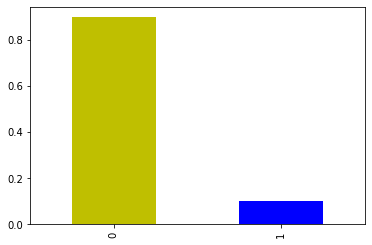

In [19]:
class_frequency=df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', color=list('yb'))

In [4]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

В нашей задаче наблюдается сильный дисбаланс классов целевого признака, отрицательных ответов ≈90% , положитительных ≈ 10%. 

## Обучение

Для обучения из соображений экономии ресурсов обрабатывается небольшая группа примеров, 15000 строк. 

In [20]:
df = df[:15000]

In [21]:
features = df.drop(['toxic'], axis=1)
target = df['toxic']

В исследовании будем использовать модель DistilBERT, предобученную для английского языка, которая представляет собой уменьшенную версию BERT'а. Она быстрее и легче своего старшего собрата, но при этом вполне сравнима в результативности.

Загрузим предобученную модели и токенизатор.

In [22]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Преобразуем текст в номера токенов из словаря методом encode(), добавляя токен начала (101) и токен конца текста (102). 

In [24]:
tokenized = features['text'].apply((lambda x: tokenizer.encode(x, max_length=300, 
                                                                   truncation=True, add_special_tokens=True)))

In [25]:
tokenized

0        [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1        [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2        [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3        [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4        [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
                               ...                        
14995    [101, 1000, 2308, 2893, 2730, 1999, 1037, 4968...
14996    [101, 2562, 2039, 1996, 2204, 2147, 1010, 1825...
14997    [101, 1000, 4165, 2307, 1012, 1006, 2831, 1528...
14998    [101, 1000, 7929, 1012, 1012, 1012, 11721, 102...
14999    [101, 1000, 12943, 3490, 1058, 10640, 1029, 21...
Name: text, Length: 15000, dtype: object

Применим метод padding, чтобы после токенизации мы могли представить входные данные как один двумерный массив, а не как список списков (разной длины).

In [26]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
print(padded)
print(max_len)

[[  101  7526  2339 ...     0     0     0]
 [  101  1040  1005 ...     0     0     0]
 [  101  4931  2158 ...     0     0     0]
 ...
 [  101  1000  4165 ...     0     0     0]
 [  101  1000  7929 ...     0     0     0]
 [  101  1000 12943 ...     0     0     0]]
300


Теперь поясним модели, что нули не несут значимой информации.

In [27]:
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

(15000, 300)


Преобразуем текст в эмбеддинги. Для этого преобразуем данные в формат тензоров(многомерных векторов)

In [ ]:
batch_size = 100 
embeddings = []

for i in range(padded.shape[0] // batch_size):
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

Соберём все эмбеддинги в матрицу признаков вызовом функции concatenate().

In [ ]:
features = np.concatenate(embeddings)
features = pd.DataFrame(features)

Разделим признаки на обучающую и тестовую выборки.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Как мы выяснили ранее в нашей выборке отрицательных ответов ≈90% , положитительных ≈ 10%.
Нам необходмо увеличить количество положительных ответов в 9 раз для достижения баланса.
- Разделим обучающую выборку на отрицательные и положительные объекты;
- Скопируем несколько раз положительные объекты;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train,9)

In [ ]:
class_frequency=target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar',color=list('yb'))

### Модель для классификации алгоритмом — логистической регрессии

In [ ]:
model_lr = LogisticRegression(random_state=12345, max_iter=1000)
model_lr.fit(features_upsampled, target_upsampled)

In [ ]:
prediction = model_lr.predict(features_test)
print('Значение f1 на тестовой выборке LogisticRegression',f1_score(target_test, prediction, average = 'weighted'))

Значение f1 на тестовой выборке LogisticRegression 0.923390134036028

### Модель для классификации деревом решений

In [ ]:
%%time
params_cat = {'max_depth': range(5, 15, 3)} 
model_DTC = DecisionTreeClassifier(random_state=12345)
grid_DTC = GridSearchCV(model_RF, params_cat, cv=5)
grid_DTC.fit(features_upsampled, target_upsampled)

In [ ]:
prediction = grid_DTC.predict(features_test)
print('Значение f1 на тестовой выборке RandomForestClassifier',f1_score(target_test, prediction,average = 'weighted'))

Значение f1 на тестовой выборке DecisionTreeClassifier на локальной машине  0.9302531897926635

###  Модель для классификации алгоритмом - "случайный лес"

In [ ]:
%%time
params_cat = {'max_depth': range(5, 15, 3),
             'n_estimators': range (5, 25, 5)} 
model_RF = RandomForestClassifier()
grid_RF = GridSearchCV(model_RF, params_cat, cv=5)
grid_RF.fit(features_upsampled, target_upsampled)

In [ ]:
prediction_RF = grid_RF.predict(features_test)
print('Значение f1 на тестовой выборке RandomForestClassifier',f1_score(target_test, prediction_RF,average = 'weighted'))

Значение f1 на тестовой выборке RandomForestClassifier 0.929242393221426

### Модель для классификации CatBoostClassifier

In [ ]:
%%time
best_est = 0
best_depth = 0
best_model = None
best_result = 0
for est in range(200,300,30):
    for depth in range(3, 12, 3):
        model_CatBoost = CatBoostClassifier(verbose=False,random_state=12345, 
                                              n_estimators=est, 
                                              max_depth=depth) 
        model_CatBoost.fit(features_upsampled,target_upsampled) 
        predicted = model_CatBoost.predict(features_test)
        result = f1_score(target_test,predicted) 
        if result > best_result: 
            best_model = model_CatBoost 
            best_result = result 
            best_depth = depth     
            best_est = est
print("Количество деревьев наилучшей модели:", best_est,
      "Максимальная глубина:", best_depth)
print(f1_score(target_test,best_model.predict(features_test), average = 'weighted'))

Значение f1 на тестовой выборке CatBoostClassifier    0.9305237658223673

## Выводы

- Для обучения модели способной классифицировать комментарии на позитивные и негативные была использована нейронная сеть  DistilBert(уменьшенная версию BERT'а). 
- Изначально предоставленные данные с сильным дисбалансом классов целевого признака, для исследования выбрали одинаковое количество положительных и отрицательных комментариев, для того чтобы классы были сбалансированы. 
- Так как DistilBert требует значительных вычеслительных ресурсов, значения таких параметров как количество исследуемых данных, ограничение длины токена(max_length), размер батча были снижены(batch_size), для того чтобы код мог выполняться на виртуальной машине. При выполении задачи на локальной машине параметры были выбраны. Размер выборки = 15000, max_length=300, batch_size = 100.
- Нейронная сеть DistilBert позволила построить модель CatBoostClassifier, классифицирующую комментарии на позитивные и негативные с наилучшим значением метрики качества F1 = 0.93

